In [19]:
from LarpixParser import event_parser as EvtParser
from LarpixParser import hit_parser as HitParser
from LarpixParser import util as util

import h5py
import numpy as np
import plotly.graph_objects as go
import yaml

In [20]:
switch_xz = False
detector = "ndlar"

In [21]:
def draw_cathode_planes(geom_dict, run_config_path, **kwargs):

    with open(run_config_path) as infile:
        run_yaml = yaml.load(infile, Loader=yaml.FullLoader)

    tpc_centers = run_yaml['tpc_offsets'] #cm
    
    pos = np.array(list(geom_dict.values())) / 10.
    traces = []
    
    for i_mod in range(len(tpc_centers)):
        x = np.array([pos[:, 0].min() + tpc_centers[i_mod][2], pos[:, 0].max() + tpc_centers[i_mod][2]])
        y = np.array([pos[:, 1].min() + tpc_centers[i_mod][1], pos[:, 1].max() + tpc_centers[i_mod][1]])
        z = np.full((2,2),  tpc_centers[i_mod][0])
        

        traces.append(go.Surface(x=x, y=y, z=z, **kwargs))
    
    return traces

In [22]:
def draw_anode_planes(geom_dict, run_config_path, **kwargs):

    with open(run_config_path) as infile:
        run_yaml = yaml.load(infile, Loader=yaml.FullLoader)

    tpc_centers = run_yaml['tpc_offsets'] #cm
    
    pos = np.array(list(geom_dict.values())) / 10.
    traces = []
    
    for i_mod in range(len(tpc_centers)):
        x = np.array([pos[:, 0].min() + tpc_centers[i_mod][2], pos[:, 0].max() + tpc_centers[i_mod][2]])
        y = np.array([pos[:, 1].min() + tpc_centers[i_mod][1], pos[:, 1].max() + tpc_centers[i_mod][1]])
        z1 = np.full((2,2),  pos[:, 2].min() + tpc_centers[i_mod][0])
        z2 = np.full((2,2),  pos[:, 2].max() + tpc_centers[i_mod][0])
        

        traces.append(go.Surface(x=x, y=y, z=z1, **kwargs))
        traces.append(go.Surface(x=x, y=y, z=z2, **kwargs))
    
    return traces

In [23]:
def plot_tracks(tracks, **kwargs):
    
    def to_list(axis):
        return np.column_stack([
            tracks[f'{axis}_start'],
            tracks[f'{axis}_end'],
            np.full(len(tracks), None)
        ]).flatten().tolist()
        
    x, y, z = (to_list(axis) for axis in 'xyz')
    trace = go.Scatter3d(x=x, y=y, z=z, **kwargs)
    
    return trace

In [24]:
f = h5py.File('../example_data/ndlar_ev20_larndsim.h5', 'r')
packets = f['packets'] # readout
G4_segments = f['tracks'] # Geant4 truth
assn = f['mc_packets_assn'] # G4-readout association
segs = f['tracks']

In [25]:
'''
    Loading LArPix geometry and run configuration
    Option 1: Use the default, the installed package data
              It's recommended, if you are not doing something unusual.
'''

run_config, geom_dict = util.detector_configuration(detector)

In [26]:
'''
    Loading LArPix geometry and run configuration
    Option 2: Point a pre-load LArPix geometry dictionary stored in a pickle file and a run configuration yaml file
'''
# geom_dict = util.load_geom_dict("../src/LarpixParser/config_repo/dict_repo/multi_tile_layout-3.0.40.pkl")

# run_config_path = '../src/LarpixParser/config_repo/ndlar-module.yaml'
# run_config = util.get_run_config(run_config_path)

'\n    Loading LArPix geometry and run configuration\n    Option 2: Point a pre-load LArPix geometry dictionary stored in a pickle file and a run configuration yaml file\n'

In [27]:
'''
    Loading LArPix geometry and run configuration
    Option 3: Build a LArPix geometry dictionary on the fly and load a run configuration yaml file
'''
# from LarpixParser import geom_to_dict as DictBuilder
# geom_repo = '../src/LarpixParser/config_repo'
# larpix_layout_name = 'multi_tile_layout-3.0.40'
# geom_dict = DictBuilder.larpix_layout_to_dict(geom_repo, larpix_layout_name, save_dict=False)

# run_config_path = '../src/LarpixParser/config_repo/ndlar-module.yaml'
# run_config = util.get_run_config(run_config_path)

'\n    Loading LArPix geometry and run configuration\n    Option 3: Build a LArPix geometry dictionary on the fly and load a run configuration yaml file\n'

In [28]:
with open(run_config_path) as infile:
    run_yaml = yaml.load(infile, Loader=yaml.FullLoader)

tpc_centers = run_yaml['tpc_offsets'] #cm

In [29]:
pckt_event_ids = EvtParser.packet_to_eventid(assn, G4_segments)
event_ids = np.unique(pckt_event_ids[pckt_event_ids != -1]) 
t0_grp = EvtParser.get_t0(packets)

In [30]:
i_ev = 4

pckt_mask = pckt_event_ids == event_ids[i_ev]
packets_ev = packets[pckt_mask]
assn_ev = assn[pckt_mask]
t0 = t0_grp[i_ev][0]

seg_ev = segs[segs['eventID'] == i_ev]

x,y,z,dQ = HitParser.hit_parser_charge(t0, packets_ev, geom_dict, run_config, switch_xz)

x = np.array(x) / 10.
y = np.array(y) / 10.
z = np.array(z) / 10.


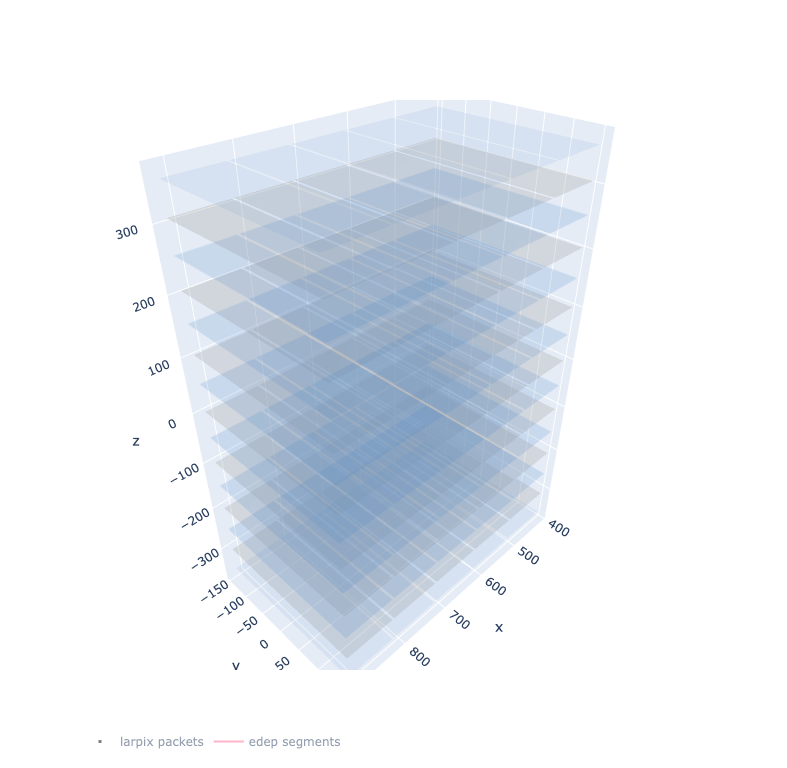

In [31]:
fig = go.Figure()

fig.add_traces(draw_cathode_planes(
    geom_dict,
    run_config_path,
    showscale=False,
    opacity=0.3,
    colorscale='Greys',
))

fig.add_traces(draw_anode_planes(
    geom_dict,
    run_config_path,
    showscale=False,
    opacity=0.1,
    colorscale='ice',
))

trace = go.Scatter3d(
        x=x, y=y, z=z,
        marker_color=dQ,
        name='larpix packets',
        mode='markers',
        visible='legendonly',
        marker_size=3,
        marker_symbol='square',
        showlegend=True,
        opacity=1.
        )

tracks = plot_tracks(seg_ev, 
                     mode="lines",
                     name="edep segments",
                     visible='legendonly',
                     showlegend=True
                     )

fig.update_layout(
    width=1024, height=768,
    legend_orientation="h",
)

fig.add_traces(trace)
fig.add_traces(tracks)
fig.show()